In [2]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import poisson
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

from multiprocessing import Pool, cpu_count
from functools import partial

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random
import time

Loaded QCD ratios from qcd_ratio_fitted_results_0p99.npz
  model0: ratio=0.072402 ± 0.000035
  model1: ratio=0.071518 ± 0.000035
  model2: ratio=0.075206 ± 0.000037
  modellite: ratio=0.071656 ± 0.000022
  ensemble: ratio=0.072719 ± 0.000039

Processing model: ../../predict/old_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3
  Found saved ROC data: roc_data/old_hh4b_resolved_newsp4_allparts_nosel_138clswtop_noweights_ddp4-bs512-lr2e-3_roc_data.npz
  Successfully loaded data.
  Downsampling loaded data (points: 138926)...

  [Downsample] Starting with 138926 points
  bg_events range: [0.00e+00, 3.38e+06]
  [Downsample] Region breakdown:
    Extreme low (< 0.1): 1121 → 1121 (kept all)
    Low (0.1-10): 235 → 235
    Mid (10-100): 1479 → 411
    High (≥ 100): 136091 → 689
  [Downsample] Total: 138926 → 2456 points

$\mathbf{Model~1}$: Original QCD statistics - Weighted signal events total: 243.66
$\mathbf{Model~1}$: Original QCD statistics - Weighted background 

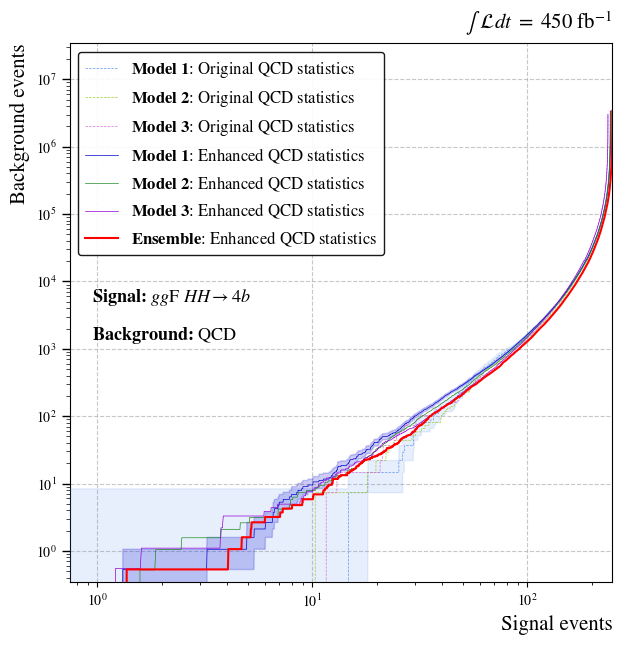

ROC curve comparison completed.


In [4]:
def load_qcd_ratios(min_cut_value=0.99):
    """Load pre-calculated QCD ratio data"""
    min_cut_value_safe = str(min_cut_value).replace('.','p')
    ratio_file = f'qcd_ratio_fitted_results_{min_cut_value_safe}.npz'
    
    try:
        data = np.load(ratio_file)
        ratios = {}
        for model in data['models']:
            ratios[str(model)] = {
                'vsqcd': float(data[f'{model}_vsqcd_ratio']),
                'vsqcd_error': float(data[f'{model}_vsqcd_ratio_error'])
            }
        print(f"Loaded QCD ratios from {ratio_file}")
        for model, vals in ratios.items():
            print(f"  {model}: ratio={vals['vsqcd']:.6f} ± {vals['vsqcd_error']:.6f}")
        return ratios
    except FileNotFoundError:
        print(f"Warning: {ratio_file} not found. Will use ellipse method for all thresholds.")
        return None

def smart_downsample_roc(fpr, tpr, thresholds, bg_lower, bg_upper, 
                         total_background, total_signal,  
                         extreme_low_threshold=0.1,    
                         low_stat_threshold=10,      
                         mid_stat_threshold=100,     
                         target_points_dict=None):    

    if target_points_dict is None:
        target_points_dict = {
            'extreme_low': None,      
            'low': 500,               
            'mid': 800,               
            'high': 700               
        }
    
    bg_events = fpr * total_background
    sig_events = tpr * total_signal
    n_points = len(fpr)
    
    if n_points <= 2500:
        print(f"  [Downsample] Points already small ({n_points}), skipping.")
        return fpr, tpr, thresholds, bg_lower, bg_upper
    
    print(f"\n  [Downsample] Starting with {n_points} points")
    print(f"  bg_events range: [{bg_events.min():.2e}, {bg_events.max():.2e}]")
    
    mask_extreme_low = bg_events < extreme_low_threshold
    idx_extreme_low = np.where(mask_extreme_low)[0]
    n_extreme = len(idx_extreme_low)
    
    mask_low = (bg_events >= extreme_low_threshold) & (bg_events < low_stat_threshold)
    idx_low_candidates = np.where(mask_low)[0]
    
    if len(idx_low_candidates) > target_points_dict['low']:
        step = max(1, len(idx_low_candidates) // target_points_dict['low'])
        idx_low = idx_low_candidates[::step]
    else:
        idx_low = idx_low_candidates
    
    mask_mid = (bg_events >= low_stat_threshold) & (bg_events < mid_stat_threshold)
    idx_mid_candidates = np.where(mask_mid)[0]
    
    if len(idx_mid_candidates) > target_points_dict['mid']:
        bg_mid = bg_events[idx_mid_candidates]
        sig_mid = sig_events[idx_mid_candidates]
        
        n_samples = target_points_dict['mid'] // 2
        
        target_bg = np.logspace(np.log10(bg_mid.min()), np.log10(bg_mid.max()), n_samples)
        idx_bg = np.searchsorted(bg_mid, target_bg)
        
        target_sig = np.logspace(np.log10(max(sig_mid.min(), 1e-10)), 
                                np.log10(sig_mid.max()), n_samples)
        idx_sig = np.searchsorted(sig_mid, target_sig)
        
        idx_mid_local = np.unique(np.concatenate([idx_bg, idx_sig]))
        idx_mid_local = np.clip(idx_mid_local, 0, len(idx_mid_candidates) - 1)
        idx_mid = idx_mid_candidates[idx_mid_local]
    else:
        idx_mid = idx_mid_candidates
    
    mask_high = bg_events >= mid_stat_threshold
    idx_high_candidates = np.where(mask_high)[0]
    
    if len(idx_high_candidates) > target_points_dict['high']:
        bg_high = bg_events[idx_high_candidates]
        sig_high = sig_events[idx_high_candidates]
        
        n_samples = target_points_dict['high'] // 2
        
        target_bg = np.logspace(np.log10(bg_high.min()), np.log10(bg_high.max()), n_samples)
        idx_bg = np.searchsorted(bg_high, target_bg)
        
        target_sig = np.logspace(np.log10(max(sig_high.min(), 1e-10)), 
                                np.log10(sig_high.max()), n_samples)
        idx_sig = np.searchsorted(sig_high, target_sig)
        
        idx_high_local = np.unique(np.concatenate([idx_bg, idx_sig]))
        idx_high_local = np.clip(idx_high_local, 0, len(idx_high_candidates) - 1)
        idx_high = idx_high_candidates[idx_high_local]
    else:
        idx_high = idx_high_candidates
    
    idx_final = np.unique(np.concatenate([idx_extreme_low, idx_low, idx_mid, idx_high]))
    idx_final = np.sort(idx_final)
    
    # Ensure start and end points are kept
    if idx_final[0] != 0:
        idx_final = np.insert(idx_final, 0, 0)
    if idx_final[-1] != n_points - 1:
        idx_final = np.append(idx_final, n_points - 1)
    
    print(f"  [Downsample] Region breakdown:")
    print(f"    Extreme low (< {extreme_low_threshold}): {n_extreme} → {n_extreme} (kept all)")
    print(f"    Low ({extreme_low_threshold}-{low_stat_threshold}): {len(idx_low_candidates)} → {len(idx_low)}")
    print(f"    Mid ({low_stat_threshold}-{mid_stat_threshold}): {len(idx_mid_candidates)} → {len(idx_mid)}")
    print(f"    High (≥ {mid_stat_threshold}): {len(idx_high_candidates)} → {len(idx_high)}")
    print(f"  [Downsample] Total: {n_points} → {len(idx_final)} points\n")
    
    return (fpr[idx_final], tpr[idx_final], thresholds[idx_final], 
            bg_lower[idx_final], bg_upper[idx_final])


def compute_hybrid_roc_custom(sig_scores, sig_weights, 
                              bg_scores_circle, bg_weights_circle, bg_is_ellipse,
                              ratio, ratio_error,
                              total_signal_norm, total_background_norm,
                              threshold_switch=0.99):

    # print(f"  Computing hybrid ROC with switch at {threshold_switch}...")
    
    n_sig = len(sig_scores)
    sig_data = np.zeros(n_sig, dtype=[('score', 'f4'), ('weight', 'f4'), ('type', 'i4'), ('in_ellipse', '?')])
    sig_data['score'] = sig_scores
    sig_data['weight'] = sig_weights
    sig_data['type'] = 1 # Signal
    sig_data['in_ellipse'] = True 
    
    n_bg = len(bg_scores_circle)
    bg_data = np.zeros(n_bg, dtype=[('score', 'f4'), ('weight', 'f4'), ('type', 'i4'), ('in_ellipse', '?')])
    bg_data['score'] = bg_scores_circle
    bg_data['weight'] = bg_weights_circle
    bg_data['type'] = 0 # Background
    bg_data['in_ellipse'] = bg_is_ellipse
    
    all_data = np.concatenate([sig_data, bg_data])
    sort_idx = np.argsort(all_data['score'])[::-1]
    sorted_data = all_data[sort_idx]
    
    weights = sorted_data['weight']
    types = sorted_data['type'] # 1=Sig, 0=Bg
    in_ellipse = sorted_data['in_ellipse']
    scores = sorted_data['score']
    
    is_sig = (types == 1)
    cumsum_sig = np.cumsum(weights * is_sig)
    
    is_bg = (types == 0)
    cumsum_bg_circle = np.cumsum(weights * is_bg)
    cumsum_bg_count_circle = np.cumsum(is_bg) 
    
    is_bg_ellipse = (types == 0) & in_ellipse
    cumsum_bg_ellipse = np.cumsum(weights * is_bg_ellipse)
    cumsum_bg_count_ellipse = np.cumsum(is_bg_ellipse) 
    
    use_ratio_method = scores > threshold_switch
    
    final_bg_yields = np.where(
        use_ratio_method,
        cumsum_bg_circle * ratio, 
        cumsum_bg_ellipse         
    )
    
    current_raw_counts = np.where(
        use_ratio_method,
        cumsum_bg_count_circle,
        cumsum_bg_count_ellipse
    )
    
    with np.errstate(divide='ignore', invalid='ignore'):
        scale_factors = final_bg_yields / current_raw_counts
        scale_factors[current_raw_counts == 0] = 0
    
    lower_raw, upper_raw = poisson.interval(0.68, current_raw_counts)
    
    mask_zero = (current_raw_counts == 0)
    upper_raw[mask_zero] = -np.log(1 - 0.68) 
    lower_raw[mask_zero] = 1e-9
    
    bg_lower = lower_raw * scale_factors
    bg_upper = upper_raw * scale_factors
    
    tpr = cumsum_sig / total_signal_norm
    fpr = final_bg_yields / total_background_norm
    
    return fpr, tpr, scores, bg_lower, bg_upper



lumi_scale = 4.5

a_param = 15
b_param = 10

circle_center_x = 125
circle_center_y = 125
circle_radius = 45

weight_dict = { # expected_total_nevents / produced_nevents
    # "QCD": lumi_scale * 4.5226e+06 * 1e5 / (17600 * 50e5), # calculate from inclusive pythia events
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5), # calculate from pre-MLM-filtered MG nevents

    # the following are calculated from inclusive nevents
    # "TTbar": lumi_scale * 83175900 / 40305472, 
    "TTbar": lumi_scale * 83175900 / (40305472 + 120928855),
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
process_list = ['ggHH','QCD']

ENSEMBLE_METHOD = "method2"

ntuple_base_dir = "/data/bond/tyyang99/HH4b/ensemble_method2_ntuples_cdfv2"

# =========================================================
# 1. Model Configuration with Paired Colors (Light/Dark)
# =========================================================
models = [
    # --- Individual Models (Original QCD / Low Stats) -> Lighter Colors ---
    {
        "name": "../../predict/old_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
        "label": r"$\mathbf{Model~1}$: Original QCD statistics",
        "color": "cornflowerblue",  # Light Blue
        "marker": "^"
    },
    {
        "name": "../../predict/old_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1",
        "label": r"$\mathbf{Model~2}$: Original QCD statistics",
        "color": "yellowgreen",     # Light Green
        "marker": "^"
    },
    {
        "name": "../../predict/old_hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2",
        "label": r"$\mathbf{Model~3}$: Original QCD statistics",
        "color": "orchid",          # Light Purple
        "marker": "^"
    },
    
    # --- Individual Models (Full Statistics) -> Darker/Vivid Colors ---
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
        "label": r"$\mathbf{Model~1}$: Enhanced QCD statistics",
        "color": "mediumblue",      # Dark Blue
        "marker": "*"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1",
        "label": r"$\mathbf{Model~2}$: Enhanced QCD statistics",
        "color": "forestgreen",     # Dark Green
        "marker": "*"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2",
        "label": r"$\mathbf{Model~3}$: Enhanced QCD statistics",
        "color": "darkviolet",      # Dark Purple
        "marker": "*"
    },

    # --- Ensemble (Highlight) ---
    {
        "name": "ensemble",
        "label": r"$\mathbf{Ensemble}$: Enhanced QCD statistics",
        "color": "red", 
        "marker": "D"
    },
]


pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

roc_data_dir = "roc_data"
os.makedirs(roc_data_dir, exist_ok=True)

qcd_ratios = load_qcd_ratios(min_cut_value=0.99)

f, ax = plt.subplots(figsize=(7,7))

# Initialize reference values
reference_total_signal = 0
reference_total_background = 0

for model_config in models:
    
    model_name = model_config["name"]
    model_safe_name = model_config["name"].replace("../../predict/","").replace("/", "_").replace(".", "_")
    print(f"\nProcessing model: {model_name}")

    # Define path to save files
    roc_file_path = f"{roc_data_dir}/{model_safe_name}_roc_data.npz"
    data_loaded = False # Flag to check if data is loaded from file

    # =========================================================
    # 1. Try to load saved ROC data directly
    # =========================================================
    if os.path.exists(roc_file_path):
        try:
            print(f"  Found saved ROC data: {roc_file_path}")
            with np.load(roc_file_path) as data:
                fpr = data['fpr']
                tpr = data['tpr']
                auc = data['auc']
                thresholds = data['thresholds']
                total_signal = data['signal']
                total_background = data['background']
                background_lower = data['background_lower']
                background_upper = data['background_upper']
            
            print("  Successfully loaded data.")
            data_loaded = True
            
            # If loaded data points are too many, perform downsampling
            if len(fpr) > 5000:
                print(f"  Downsampling loaded data (points: {len(fpr)})...")
                fpr, tpr, thresholds, background_lower, background_upper = smart_downsample_roc(
                    fpr, tpr, thresholds, background_lower, background_upper, 
                    total_background,
                    total_signal,
                )
                
        except Exception as e:
            print(f"  Error loading saved file: {e}. Will recalculate.")
            data_loaded = False

    # =========================================================
    # 2. If loading failed, calculate (Hybrid or Standard)
    # =========================================================
    if not data_loaded:
        
        is_ellipse_model = (
            "hh4b_resolved_newsp4_allparts_nosel" in model_name or 
            model_name == "ensemble"
        )
        
        # Determine Ratio Key
        if model_name == "ensemble":
            ratio_model_key = "ensemble"
        elif ".model1" in model_name:
            ratio_model_key = "model1"
        elif ".model2" in model_name:
            ratio_model_key = "model2"
        elif "ndiv10.ddp4-bs400-lr1p6e-3.wd0p01" in model_name:
            ratio_model_key = "modellite"
        elif "hh4b_resolved_newsp4_allparts_nosel" in model_name:
            ratio_model_key = "model0"
        else:
            ratio_model_key = None

        # -------------------------------------------------------
        # Branch A: Ellipse Model (Ntuple + Hybrid Logic)
        # -------------------------------------------------------
        if is_ellipse_model: 
            print(f"  Calculating from scratch: Loading ntuples with Hybrid Logic...")
            
            signal_data = []
            background_data = []
            
            # Define model prefix
            if model_name == "ensemble":
                model_prefix = "ensemble" 
            elif ".model1" in model_name:
                model_prefix = "model1"
            elif ".model2" in model_name:
                model_prefix = "model2"
            elif "ndiv10" in model_name:
                model_prefix = "modellite"
            else:
                model_prefix = "model0"

            for proc_name in process_list:
                proc_dir = os.path.join(ntuple_base_dir, proc_name)
                if not os.path.exists(proc_dir): continue
                
                is_signal = proc_name in ["ggHH", "qqHH"]
                ntuple_files = glob.glob(os.path.join(proc_dir, "ensemble_method2_*.root"))
                
                # print(f"Processing {proc_name}: found {len(ntuple_files)} files")
                
                for ntuple_file in ntuple_files:
                    try:
                        with uproot.open(ntuple_file) as f:
                            tree = f["tree"]
                            
                            # Build list of branches to read
                            branches = ['weight', 'combined_basic_fit_cut']
                            
                            # Coordinates
                            if model_name == "ensemble":
                                branches.extend(['ensemble_final_peak_x', 'ensemble_final_peak_y'])
                                branches.extend(['model0_score_hh4bvsqcd', 'model1_score_hh4bvsqcd', 'model2_score_hh4bvsqcd'])
                            else:
                                branches.extend([f'{model_prefix}_final_peak_x', f'{model_prefix}_final_peak_y'])
                                branches.extend([f'{model_prefix}_score_hh4bvsqcd', f'{model_prefix}_basic_fit_cut'])

                            data = tree.arrays(branches)
                        
                        # 1. Basic Fit Cut
                        if model_name == "ensemble":
                            fit_cut = data['combined_basic_fit_cut'] == 1
                        else:
                            fit_cut = data[f'{model_prefix}_basic_fit_cut'] == 1
                        
                        if ak.sum(fit_cut) == 0: continue
                        
                        # Extract coordinates
                        if model_name == "ensemble":
                            peak_x = data['ensemble_final_peak_x'][fit_cut]
                            peak_y = data['ensemble_final_peak_y'][fit_cut]
                        else:
                            peak_x = data[f'{model_prefix}_final_peak_x'][fit_cut]
                            peak_y = data[f'{model_prefix}_final_peak_y'][fit_cut]

                        # 2. Define geometric region cuts
                        ellipse_cut_mask = (
                            ((peak_x + peak_y - 250)**2 / (2 * a_param**2) +
                             (peak_x - peak_y)**2 / (2 * b_param**2)) < 1
                        )
                        
                        circle_cut_mask = (
                            (peak_x - circle_center_x)**2 + 
                            (peak_y - circle_center_y)**2 < circle_radius**2
                        )

                        # 3. Extract scores and weights
                        weights_arr = ak.to_numpy(data['weight'][fit_cut])
                        
                        if model_name == "ensemble":
                            s0 = ak.to_numpy(data['model0_score_hh4bvsqcd'][fit_cut])
                            s1 = ak.to_numpy(data['model1_score_hh4bvsqcd'][fit_cut])
                            s2 = ak.to_numpy(data['model2_score_hh4bvsqcd'][fit_cut])
                            scores_arr = (s0 + s1 + s2) / 3.0
                        else:
                            scores_arr = ak.to_numpy(data[f'{model_prefix}_score_hh4bvsqcd'][fit_cut])

                        # 4. Apply different selection strategies based on Signal/Background
                        if is_signal:
                            final_mask = ellipse_cut_mask
                            if ak.sum(final_mask) == 0: continue
                            
                            weighted_data = {
                                'score': scores_arr[final_mask],
                                'weight': weights_arr[final_mask],
                            }
                            signal_data.append(weighted_data)
                            
                        else: # Background
                            final_mask = circle_cut_mask
                            if ak.sum(final_mask) == 0: continue
                            
                            in_ellipse_flag = ellipse_cut_mask[final_mask]
                            
                            weighted_data = {
                                'score': scores_arr[final_mask],
                                'weight': weights_arr[final_mask],
                                'in_ellipse': ak.to_numpy(in_ellipse_flag),
                                'in_circle': np.ones(np.sum(final_mask), dtype=bool)
                            }
                            background_data.append(weighted_data)

                    except Exception as e:
                        print(f"  Error loading {ntuple_file}: {e}")
                        continue

            if not signal_data or not background_data:
                print(f"Warning: Model {model_name} doesn't have enough data")
                continue

            # Merge data
            y_score_s = np.concatenate([d['score'] for d in signal_data])
            y_weight_s = np.concatenate([d['weight'] for d in signal_data])
            
            y_score_b_circle = np.concatenate([d['score'] for d in background_data])
            y_weight_b_circle = np.concatenate([d['weight'] for d in background_data])
            y_bg_is_ellipse = np.concatenate([d['in_ellipse'] for d in background_data])
            
            total_signal = np.sum(y_weight_s)
            total_background = np.sum(y_weight_b_circle[y_bg_is_ellipse])
            
            print(f"  Data loaded. Sig(Ellipse): {len(y_score_s)}, Bg(Circle): {len(y_score_b_circle)}")

            # Calculate Hybrid ROC
            if qcd_ratios and ratio_model_key and ratio_model_key in qcd_ratios:
                model_ratio = qcd_ratios[ratio_model_key]['vsqcd']
                model_ratio_error = qcd_ratios[ratio_model_key]['vsqcd_error']
                
                fpr, tpr, thresholds, background_lower, background_upper = compute_hybrid_roc_custom(
                    y_score_s, y_weight_s,
                    y_score_b_circle, y_weight_b_circle, y_bg_is_ellipse,
                    model_ratio, model_ratio_error,
                    total_signal, total_background,
                    threshold_switch=0.99
                )
                try:
                    auc = m.auc(fpr, tpr)
                except ValueError:
                    auc = np.trapz(tpr, fpr) 
                    print(f"  Note: ROC non-monotonic at stitching point. AUC calculated via trapz: {auc:.4f}")
            else:
                # Fallback: Standard ROC
                print("  Fallback to standard ROC (Ellipse only)...")
                y_score_b_ellipse = y_score_b_circle[y_bg_is_ellipse]
                y_weight_b_ellipse = y_weight_b_circle[y_bg_is_ellipse]
                
                y_true = np.concatenate([np.ones(len(y_score_s)), np.zeros(len(y_score_b_ellipse))])
                y_score = np.concatenate([y_score_s, y_score_b_ellipse])
                y_weight = np.concatenate([y_weight_s, y_weight_b_ellipse])
                
                fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
                auc = m.auc(fpr, tpr)
                
                # Standard Poisson Error
                y_score_b_np = np.asarray(y_score_b_ellipse)
                total_raw_b = len(y_score_b_np)
                if total_raw_b == 0:
                    background_lower = np.zeros_like(thresholds)
                    background_upper = np.zeros_like(thresholds)
                else:
                    weight_per_b = total_background / total_raw_b
                    sorted_scores_asc = np.sort(y_score_b_np)
                    pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')
                    raw_background_passed = total_raw_b - pos
                    lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
                    mask_zero = (raw_background_passed == 0)
                    upper_raw[mask_zero] = -np.log(1 - 0.68)
                    lower_raw[mask_zero] = 1e-9
                    background_lower = lower_raw * weight_per_b
                    background_upper = upper_raw * weight_per_b

        # -------------------------------------------------------
        # Branch B: Standard Model (Prediction Files)
        # -------------------------------------------------------
        else:
            print(f"  Calculating from scratch: Loading original prediction files...")
            
            signal_data = []
            background_data = []
            
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if not proc_name in process_list: continue
                if "forInfer2" in ifolder: continue
                
                is_signal = proc_name in ["ggHH", "qqHH"]
                weight = weight_dict.get(proc_name, 1.0)
                
                matching_files = glob.glob(ifolder + "/*")
                if proc_name == "QCD" or proc_name == "TTbar":
                    ext_folder = ifolder.replace("forInfer", "forInfer2")
                    matching_files += glob.glob(ext_folder + "/*")
                
                for idxf, ifile in enumerate(matching_files):
                    if "forInfer2" in ifile:
                        name = proc_name + "EXT_" + ifile.replace(".root","").split("_")[-1]
                    else:
                        name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    
                    pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
                    
                    try:
                        pred_data_tmp = uproot.lazy(pred_file)
                        pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & 
                                                 (pred_data_tmp['pass_4j3b_selection']==1)]
                        
                        if model_name == "hh4b_resolved_ghostmatching_4highbtagjets.noweights":
                            pred_data = pred_data[pred_data['pass_4b_selection']==1]
                        
                        pred_data['score_hh4bvsqcd'] = pred_data['score_is_hh4b'] / (
                            pred_data['score_is_hh4b'] + pred_data['score_is_qcd'])
                        
                        weighted_data = {
                            'score': ak.to_numpy(pred_data['score_hh4bvsqcd']),
                            'weight': np.ones(len(pred_data)) * weight
                        }
                        if is_signal: signal_data.append(weighted_data)
                        else: background_data.append(weighted_data)
                            
                    except Exception as e:
                        print(f"Error processing file {pred_file}: {e}")
            
            if not signal_data or not background_data:
                print(f"Warning: Model {model_name} doesn't have enough data")
                continue
                
            y_score_s = np.concatenate([d['score'] for d in signal_data])
            y_weight_s = np.concatenate([d['weight'] for d in signal_data])
            y_score_b = np.concatenate([d['score'] for d in background_data])
            y_weight_b = np.concatenate([d['weight'] for d in background_data])
            
            y_score = np.concatenate([y_score_s, y_score_b])
            y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
            y_weight = np.concatenate([y_weight_s, y_weight_b])
            
            valid_mask = ~np.isnan(y_score)
            y_true = y_true[valid_mask]
            y_score = y_score[valid_mask]
            y_weight = y_weight[valid_mask]
            y_score_b = y_score_b[~np.isnan(y_score_b)]
            
            total_signal = np.sum(y_weight_s)
            total_background = np.sum(y_weight_b)
            
            fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
            auc = m.auc(fpr, tpr)

            # Standard Poisson Error
            y_score_b_np = np.asarray(y_score_b)
            total_raw_b = len(y_score_b_np)
            if total_raw_b == 0:
                background_lower = np.zeros_like(thresholds)
                background_upper = np.zeros_like(thresholds)
            else:
                weight_per_b = total_background / total_raw_b
                sorted_scores_asc = np.sort(y_score_b_np)
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')
                raw_background_passed = total_raw_b - pos
                lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
                mask_zero = (raw_background_passed == 0)
                upper_raw[mask_zero] = -np.log(1 - 0.68)
                lower_raw[mask_zero] = 1e-9
                background_lower = lower_raw * weight_per_b
                background_upper = upper_raw * weight_per_b

        # -------------------------------------------------------
        # General step: Save data (regardless of calculation branch)
        # -------------------------------------------------------
        print(f"  Saving ROC data to {roc_file_path}...")
        np.savez(roc_file_path, 
                 fpr=fpr, tpr=tpr, thresholds=thresholds, auc=auc,
                 signal=total_signal, background=total_background,
                 background_lower=background_lower, background_upper=background_upper)
        
        # Downsample after calculation (for plotting)
        print(f"Original points: {len(fpr)}")
        fpr, tpr, thresholds, background_lower, background_upper = smart_downsample_roc(
            fpr, tpr, thresholds, background_lower, background_upper, 
            total_background,
            total_signal,
        )
        print(f"Downsampled points: {len(fpr)}")

    # =========================================================
    # 3. Plotting (regardless of data source)
    # =========================================================
    print(f"{model_config['label']} - Weighted signal events total: {total_signal:.2f}")
    print(f"{model_config['label']} - Weighted background events total: {total_background:.2f}")
    
    # if model_config['name'] == "hh4b_resolved_ghostmatching_alljets_allscores_log.noweights":
    #     reference_total_signal = total_signal
    #     reference_total_background = total_background

    reference_total_signal = max(reference_total_signal, total_signal)
    reference_total_background = max(reference_total_background, total_background)
    
    signal_events = tpr * total_signal
    background_events = fpr * total_background
    background_lower = np.maximum(background_lower, 1e-10)

    linewidth = 2.0
    zorder = 5
    
    if model_name == "ensemble":
        linestyle = '-'
        linewidth = 1.5 # Make ensemble slightly thicker
        zorder = 10     # Put ensemble on top
    elif "old_" in model_name or "original" in model_config['label'].lower():
        linestyle = '--' # Dashed for old/original QCD
        linewidth = 0.5
    else:
        linestyle = '-'  # Solid for new/full stats
        linewidth = 0.5
    
    # Plot the line
    line, = ax.plot(signal_events, background_events, 
            color=model_config['color'],
            linestyle=linestyle,
            linewidth=linewidth,
            zorder=zorder,
            label=model_config['label'])

    # Fill between (make it lighter for old models to avoid clutter)
    if "Model~1" in model_config['label']:
        # Lighter alpha for the band
        alpha_val = 0.2 if linestyle == '-' else 0.15
        ax.fill_between(signal_events, background_lower, background_upper, 
                        color=model_config['color'], alpha=alpha_val, zorder=zorder-1)

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

from matplotlib.ticker import LogLocator, LogFormatterMathtext
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax.yaxis.set_major_formatter(LogFormatterMathtext())

ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=100))
ax.tick_params(axis='y', which='minor', length=3, width=0.5) 
ax.tick_params(axis='y', which='major', length=6, width=1)

x_min = 3e-3 * reference_total_signal
x_max = reference_total_signal 
y_min = 1e-7 * reference_total_background
y_max = reference_total_background * 10

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel(r'Signal events', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background events', ha='right', y=1.0, fontsize=15)

ax.text(0.04, 0.52, r'Signal: $gg\mathrm{F}~HH\rightarrow 4b$', fontsize=13, fontweight='bold', transform=ax.transAxes)
ax.text(0.04, 0.45, r'Background: $\mathrm{QCD}$', fontsize=13, fontweight='bold', transform=ax.transAxes)

ax.text(1.0, 1.01, r'$\int~\mathcal{L}dt~=~450$ fb$^{-1}$', fontsize=15, 
        transform=ax.transAxes, ha='right', va='bottom')

handles, labels = ax.get_legend_handles_labels()

cms_handles = []
cms_labels = []
other_handles = []
other_labels = []

for i, label in enumerate(labels):
    other_handles.append(handles[i])
    other_labels.append(labels[i])

final_handles = cms_handles + other_handles
final_labels = cms_labels + other_labels

ax.legend(final_handles, final_labels, loc='upper left', framealpha=0.9, edgecolor='black', fontsize=12,
         handler_map={tuple: HandlerTuple(ndivide=None)})

plt.savefig('PLOTS/check_roc_hh4b_vs_qcd_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('PLOTS/check_roc_hh4b_vs_qcd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curve comparison completed.")
